# Table of Content
   ### Introduction
   ### 1. Data Preparation
   ### 2. Feature Selection
   ### 3. Feature Enginering
   ### 4. Modeling
   ### 5. Grid Search
   ### 6. Model Selection and Hyperparameter Tuning
   ### 7. Export Best Model for Deployment
 

# Introduction

Provided anonymized dataset contains a large number of numeric variables. The "TARGET" column is the variable to predict. It equals one for unsatisfied customers and 0 for satisfied customers.

The task is to predict the probability that each customer in the test set is an unsatisfied customer.

File descriptions<br>
train.csv - the training set including the target<br>
test.csv - the test set without the target<br>
sample_submission.csv - a sample submission file in the correct format<br>



### Project Flow Chart
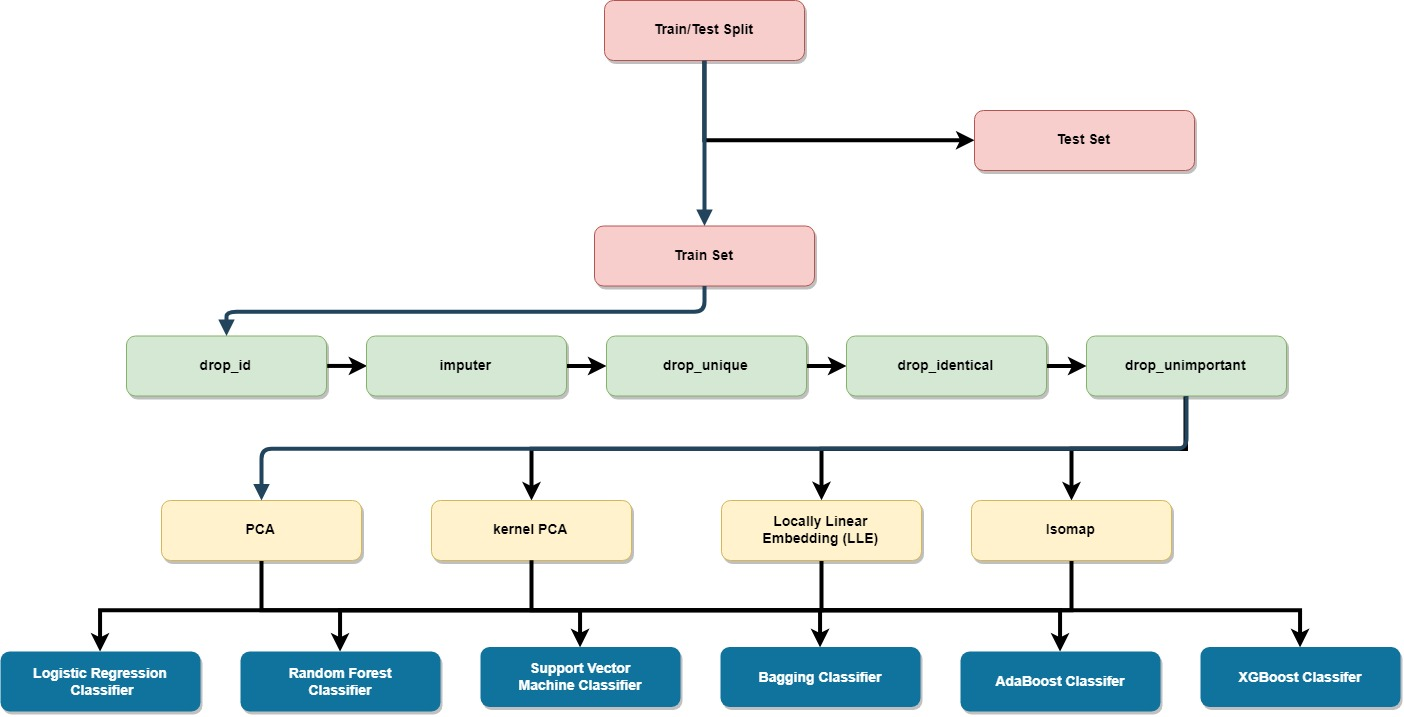

### Python Libraries

In [1]:
#  Libraries
import os
import glob

# Data extraction and manipulation
import pandas as pd
import numpy as np
import pickle
import joblib
from itertools import combinations


# Data visualization
from pandas.plotting import autocorrelation_plot
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

# Satistical Analysis and Preprocessing
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import BaseEstimator, TransformerMixin

# Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE

# Modelers
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier,
                              VotingClassifier, GradientBoostingClassifier, AdaBoostClassifier)
from sklearn.tree import DecisionTreeClassifier
import xgboost 

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
random_state = 42

In [3]:
files = glob.glob('./pipelines/*')
for f in files:
    os.remove(f)

In [4]:
# Read Data
df_train = pd.read_csv("./dataset/train.csv")

df = df_train.head(2000)

In [5]:
sum(df.TARGET==1)

76

In [6]:
# Pipeline elements for sckit-learn
pipeline = []

# 1. Data Preparation
### Train/Test Split

First step is to split our data into two parts, train set and test test. But we need to make sure that the ratio of TARGET value is preserved. So we evaluate the distribution of TARGET feature values.

In [7]:
print(df.info())
df.TARGET.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 5.7 MB
None


0    1924
1      76
Name: TARGET, dtype: int64

It can be seen that data is imbalanced so we use stratified sampling to preserve the each catagory ratio.

In [8]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)

for train_index, test_index in split.split(df, df.TARGET):
    tr = df.loc[train_index]             #Stratified train set
    ts = df.loc[test_index]              #Stratified test set    
tr.reset_index(inplace=True, drop=True)
ts.reset_index(inplace=True, drop=True)

In [9]:
print(f'Train set TARGET ratio \n{tr.TARGET.value_counts(normalize=True)} \n')
print(f'Test set TARGET ratio \n{ts.TARGET.value_counts(normalize=True)}')

Train set TARGET ratio 
0    0.961875
1    0.038125
Name: TARGET, dtype: float64 

Test set TARGET ratio 
0    0.9625
1    0.0375
Name: TARGET, dtype: float64


# 2. Feature Selection

### 2.0 dropping ID 
ID can be considered as a feature, so we drop it.

In [10]:
def drop_id(X):
    return X.drop(columns=["ID"])

# Pipeline #0: drop_id
fs_pl0 = ('drop_id', FunctionTransformer(drop_id, validate=False))

### 2.1 Feature types

Now that test set has been put aside , we can work on our train set with ease of mind. Let's have a look at the columns.

#### 2.1.1 Catagorical features
First let's see how many of our features are of caragorical data type.

In [11]:
tr.select_dtypes(['object', 'category']).columns

Index([], dtype='object')

None of them are of catagorical data type, which is not normal, it probably means all of them have been mapped to numbers already. <br>
#### 2.1.2 Numerical features

In [12]:
tr.select_dtypes(exclude=['object', 'category']).columns

Index(['ID', 'var3', 'var15', 'imp_ent_var16_ult1', 'imp_op_var39_comer_ult1',
       'imp_op_var39_comer_ult3', 'imp_op_var40_comer_ult1',
       'imp_op_var40_comer_ult3', 'imp_op_var40_efect_ult1',
       'imp_op_var40_efect_ult3',
       ...
       'saldo_medio_var33_hace2', 'saldo_medio_var33_hace3',
       'saldo_medio_var33_ult1', 'saldo_medio_var33_ult3',
       'saldo_medio_var44_hace2', 'saldo_medio_var44_hace3',
       'saldo_medio_var44_ult1', 'saldo_medio_var44_ult3', 'var38', 'TARGET'],
      dtype='object', length=371)

### 2.2 Missing Values

For various reasons, many real world datasets contain missing values, often encoded as blanks, NaNs or other placeholders. Such datasets however are incompatible with scikit-learn estimators which assume that all values in an array are numerical, and that all have and hold meaning. A basic strategy to use incomplete datasets is to discard entire rows and/or columns containing missing values. However, this comes at the price of losing data which may be valuable (even though incomplete). A better strategy is to impute the missing values, i.e., to infer them from the known part of the data.<br>

#### 2.2.1 Univariate feature imputation
The SimpleImputer class provides basic strategies for imputing missing values. Missing values can be imputed with a provided constant value, or using the statistics (mean, median or most frequent) of each column in which the missing values are located. This class also allows for different missing values encodings.


In [13]:
# tr.describe().transpose().sort_values(by='count').to_excel("tr.describe.xlsx")

No missing value! But it's always helpful to have a missing value handler. So when the predictor goes live, it would be capable of handling any missing value.<br>
We add a simple imputer with median as the filling strategy. 

In [14]:
# Pipeline #1: imputer
fs_pl1 = ('imputer', SimpleImputer(strategy="median", fill_value='missing'))

### 2.3 Single unique value

Features with only one unique value will not have any effect on predictor, so we drop them.

In [15]:
def drop_unique(X):  
    try:
        with open("./pipelines/drop_unique.txt", "rb") as fp:
            feats = pickle.load(fp)
    
    except IOError:
        col = X.nunique()
        feats = list(col[col>1].index)
        with open("./pipelines/drop_unique.txt", "wb") as fp:
            pickle.dump(feats, fp)
    
    return X[feats]

# Pipeline #2: drop_unique
fs_pl2 = ('drop_unique', FunctionTransformer(drop_unique, validate=False))

### 2.4 Identical Features

Some features are repeated more than one and they are identical, so we drop them.

In [16]:
def drop_identical(X):
    
    def getDuplicateColumns(df):
        feats = list(combinations(X.columns.tolist(),2))
        return [f[1] for f in feats if np.array_equal(X[f[0]],X[f[1]])]
    
    try:
        with open("./pipelines/drop_identical.txt", "rb") as fp:
            feats = pickle.load(fp)
    
    except IOError:
        
        feats = getDuplicateColumns(X)
        
        with open("./pipelines/drop_identical.txt", "wb") as fp:
            pickle.dump(feats, fp)

    return X.drop(columns=feats)

# Pipeline #3: drop_identical
fs_pl3 = ('drop_identical', FunctionTransformer(drop_identical, validate=False))

### 2.4 Feature Importance

Random forest consists of a number of decision trees. Every node in the decision trees is a condition on a single feature, designed to split the dataset into two so that similar response values end up in the same set. The measure based on which the (locally) optimal condition is chosen is called impurity. For classification, it is typically either Gini impurity or information gain/entropy and for regression trees it is variance. Thus when training a tree, it can be computed how much each feature decreases the weighted impurity in a tree. For a forest, the impurity decrease from each feature can be averaged and the features are ranked according to this measure.<br>
There are a few things to keep in mind when using the impurity based ranking. Firstly, feature selection based on impurity reduction is biased towards preferring variables with more categories. Secondly, when the dataset has two (or more) correlated features, then from the point of view of the model, any of these correlated features can be used as the predictor, with no concrete preference of one over the others. But once one of them is used, the importance of others is significantly reduced since effectively the impurity they can remove is already removed by the first feature. As a consequence, they will have a lower reported importance. This is not an issue when we want to use feature selection to reduce overfitting, since it makes sense to remove features that are mostly duplicated by other features. But when interpreting the data, it can lead to the incorrect conclusion that one of the variables is a strong predictor while the others in the same group are unimportant, while actually they are very close in terms of their relationship with the response variable.

In [17]:
def drop_unimportant(x):
    
    try:
        with open("./pipelines/drop_unimportant.txt", "rb") as fp:
            feats = pickle.load(fp)
    
    except IOError:
    
        # Threshold of score
        Score = 0
        feats = []

        X=(x-x.min())/(x.max()-x.min())

        rnd_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
        rnd_clf.fit(X.drop(columns=["TARGET"]), X["TARGET"])
        for name, score in sorted(zip(X.drop(columns=["TARGET"]).columns, rnd_clf.feature_importances_), 
                                  key=lambda x:x[1], reverse=True):
            if score>Score: feats.append(name)

        feats.append("TARGET")
        
        with open("./pipelines/drop_unimportant.txt", "wb") as fp:
            pickle.dump(feats, fp)
    
    return x[feats]

# Pipeline #3: drop_identical
fs_pl4 = ('drop_unimportant', FunctionTransformer(drop_unimportant, validate=False))

In [18]:
FS_pipe = Pipeline([fs_pl0, fs_pl2, fs_pl3, fs_pl4])

df_FS_pipe = FS_pipe.fit_transform(tr)

### 2.5 Summary of Feature Selection

In order to create the final pipeline we hardcode all the selected features into one pipeline to be used for the next steps.

In [19]:
print(df_FS_pipe.columns.tolist())

['var38', 'var15', 'saldo_medio_var5_ult3', 'saldo_medio_var5_hace3', 'num_var45_hace3', 'num_var45_ult3', 'num_var22_ult3', 'saldo_var42', 'saldo_var30', 'saldo_var5', 'saldo_medio_var5_hace2', 'saldo_medio_var5_ult1', 'num_var22_ult1', 'num_var22_hace3', 'num_var45_hace2', 'num_meses_var39_vig_ult3', 'imp_op_var41_comer_ult1', 'var36', 'imp_op_var41_ult1', 'num_med_var45_ult3', 'num_meses_var5_ult3', 'num_var45_ult1', 'imp_op_var39_ult1', 'ind_var7_recib_ult1', 'num_var4', 'imp_ent_var16_ult1', 'num_var22_hace2', 'imp_op_var41_efect_ult3', 'num_var35', 'imp_op_var41_efect_ult1', 'imp_op_var41_comer_ult3', 'imp_op_var39_efect_ult3', 'imp_op_var39_comer_ult1', 'num_ent_var16_ult1', 'num_var43_emit_ult1', 'num_op_var39_ult3', 'num_var7_recib_ult1', 'imp_trans_var37_ult1', 'imp_op_var39_efect_ult1', 'imp_op_var39_comer_ult3', 'num_op_var41_ult3', 'num_med_var22_ult3', 'imp_var43_emit_ult1', 'num_var43_recib_ult1', 'imp_var7_recib_ult1', 'var3', 'num_var41_0', 'ind_var41_0', 'num_op_var41

In [20]:
class selected_features(BaseEstimator, TransformerMixin):

    def transform(self, X):
        feats = ['var38', 'var15', 'saldo_medio_var5_ult3', 'num_var45_ult3', 'saldo_medio_var5_hace3', 'num_var45_hace3', 
                 'saldo_medio_var5_hace2', 'num_var22_ult3', 'num_var45_hace2', 'saldo_medio_var5_ult1', 'saldo_var30', 
                 'saldo_var42', 'saldo_var5', 'num_var45_ult1', 'num_var22_hace2', 'num_med_var45_ult3', 'num_var22_hace3',
                 'num_var22_ult1', 'var36', 'num_meses_var39_vig_ult3', 'num_meses_var5_ult3', 'num_med_var22_ult3', 
                 'num_var35', 'imp_op_var39_ult1', 'imp_op_var41_comer_ult3', 'imp_op_var41_ult1', 'imp_op_var39_comer_ult3',
                 'num_var4', 'imp_op_var41_efect_ult3', 'imp_trans_var37_ult1', 'imp_op_var39_efect_ult3',
                 'imp_op_var39_comer_ult1', 'num_op_var39_ult3', 'num_op_var41_ult3', 'imp_op_var41_comer_ult1', 
                 'ind_var5', 'imp_op_var41_efect_ult1', 'var3', 'imp_op_var39_efect_ult1', 'num_op_var39_comer_ult3', 
                 'imp_ent_var16_ult1', 'saldo_var37', 'num_op_var39_ult1', 'num_op_var41_hace2', 'num_var30', 
                 'num_op_var41_ult1', 'imp_var43_emit_ult1', 'num_op_var41_comer_ult3', 'num_op_var41_efect_ult3', 
                 'num_op_var39_efect_ult3', 'num_op_var39_hace2', 'ind_var30', 'num_op_var41_comer_ult1', 'num_var5',
                 'num_op_var39_comer_ult1', 'num_var43_recib_ult1', 'num_var42', 'num_var39_0', 'num_ent_var16_ult1', 
                 'num_var41_0', 'saldo_medio_var8_ult1', 'saldo_medio_var8_ult3', 'num_var43_emit_ult1', 'num_var37_0', 
                 'num_op_var39_efect_ult1', 'saldo_var8', 'num_op_var41_efect_ult1', 'num_var37_med_ult2', 
                 'ind_var43_recib_ult1', 'num_var5_0', 'num_var30_0', 'num_var42_0', 'num_var8_0', 'ind_var8_0',
                 'saldo_var26', 'ind_var41_0', 'ind_var39_0', 'saldo_medio_var8_hace2', 'saldo_var25',
                 'ind_var43_emit_ult1', 'ind_var10cte_ult1', 'ind_var37_cte', 'saldo_medio_var12_ult1', 
                 'ind_var9_cte_ult1', 'ind_var9_ult1', 'saldo_medio_var13_corto_ult3', 'num_trasp_var11_ult1', 
                 'ind_var37_0', 'ind_var10_ult1', 'saldo_var12', 'ind_var5_0', 'num_var26_0', 'saldo_medio_var12_ult3', 
                 'saldo_medio_var12_hace2', 'ind_var12_0', 'num_op_var39_hace3', 'saldo_medio_var13_corto_hace2',
                 'num_var12_0', 'saldo_medio_var8_hace3', 'saldo_var13_corto', 'num_var25_0', 'num_meses_var8_ult3', 
                 'imp_op_var40_efect_ult1', 'num_op_var41_hace3', 'num_var24_0', 'saldo_var13', 
                 'saldo_medio_var13_corto_ult1', 'saldo_var24', 'num_sal_var16_ult1', 'imp_sal_var16_ult1', 'ind_var26_cte',
                 'imp_var7_recib_ult1', 'var21', 'imp_op_var40_efect_ult3', 'num_var14_0', 'ind_var25_cte', 
                 'num_meses_var12_ult3', 'num_var13', 'ind_var24_0', 'ind_var8', 'ind_var26_0', 
                 'num_meses_var13_corto_ult3', 'saldo_medio_var12_hace3', 'num_var1_0', 'ind_var25_0', 'saldo_var40', 
                 'num_var40_0', 'ind_var13_0', 'num_var7_recib_ult1', 'num_var12', 'ind_var14_0', 'num_op_var40_efect_ult3',
                 'num_var13_0', 'num_var8', 'saldo_var1', 'ind_var30_0', 'ind_var1_0', 'num_op_var40_efect_ult1',
                 'ind_var7_recib_ult1', 'ind_var13', 'saldo_var14', 'num_op_var40_ult1', 'num_op_var40_comer_ult3',
                 'ind_var12', 'ind_var40_0', 'ind_var13_corto_0', 'saldo_var32', 'num_var24', 'num_op_var40_comer_ult1', 
                 'imp_op_var40_comer_ult3', 'imp_op_var40_comer_ult1', 'ind_var24', 'num_op_var40_ult3', 'num_var13_corto',
                 'num_var13_corto_0', 'ind_var14', 'imp_op_var40_ult1', 'ind_var13_corto', 'saldo_medio_var13_corto_hace3',
                 'num_var32_0', 'imp_aport_var13_hace3', 'ind_var32_cte', 'imp_aport_var13_ult1', 'saldo_var44',
                 'saldo_var13_largo', 'num_aport_var13_hace3', 'num_aport_var17_ult1', 'ind_var1', 'ind_var13_largo', 
                 'imp_reemb_var13_ult1', 'saldo_medio_var17_ult3', 'num_reemb_var17_ult1', 'ind_var40', 'num_var14', 
                 'saldo_medio_var44_ult1', 'num_var1', 'imp_compra_var44_ult1', 'ind_var19', 'saldo_var31', 'ind_var31_0',
                 'num_op_var40_hace2', 'imp_reemb_var17_ult1', 'ind_var13_largo_0', 'imp_aport_var17_ult1', 'num_var40',
                 'ind_var32_0', 'num_var13_largo_0', 'delta_num_aport_var13_1y3', 'num_var31', 'delta_imp_aport_var13_1y3',
                 'num_var31_0', 'num_reemb_var13_ult1', 'num_aport_var13_ult1', 'num_var13_largo', 'num_var17_0', 
                 'saldo_medio_var17_ult1', 'ind_var31', 'delta_num_compra_var44_1y3', 'ind_var20_0', 'ind_var44_0', 
                 'saldo_medio_var44_ult3', 'num_meses_var13_largo_ult3', 'num_meses_var44_ult3', 'num_var20_0', 
                 'saldo_medio_var13_largo_ult1', 'delta_imp_reemb_var13_1y3', 'ind_var44', 'num_compra_var44_ult1', 
                 'ind_var17_0', 'num_var33_0', 'saldo_medio_var13_largo_hace2', 'delta_num_venta_var44_1y3', 'num_var44_0',
                 'num_var17', 'delta_imp_compra_var44_1y3', 'num_meses_var17_ult3', 'saldo_medio_var13_largo_ult3', 
                 'saldo_var17', 'num_var44', 'saldo_medio_var17_hace2', 'delta_imp_venta_var44_1y3', 
                 'delta_imp_reemb_var17_1y3', 'saldo_medio_var33_ult1', 'saldo_medio_var44_hace2', 'saldo_var20',
                 'imp_venta_var44_ult1', 'saldo_medio_var13_largo_hace3', 'num_meses_var33_ult3', 'imp_aport_var33_ult1',
                 'ind_var33_0', 'ind_var20', 'delta_imp_trasp_var33_out_1y3', 'imp_venta_var44_hace3', 'ind_var17', 
                 'delta_imp_aport_var17_1y3', 'saldo_medio_var33_ult3', 'delta_num_aport_var17_1y3', 'num_var33', 
                 'num_aport_var33_hace3', 'saldo_var33', 'num_venta_var44_ult1', 'num_trasp_var33_in_hace3', 
                 'saldo_medio_var33_hace2', 'imp_aport_var17_hace3', 'saldo_medio_var33_hace3', 'ind_var6_0', 
                 'saldo_medio_var44_hace3', 'num_var20', 'imp_trasp_var33_in_ult1', 'imp_trasp_var17_out_ult1', 
                 'imp_trasp_var17_in_ult1', 'delta_imp_aport_var33_1y3', 'num_compra_var44_hace3']
        
        return X[feats]

    def fit(self, X, y=None):
        return self


# Just this pipeline to be used for the next steps
fs_pl = ('selected_features', selected_features())

# 3. Feature Engineering

A critical part of the success of a Machine Learning project is coming up with a
good set of features to train on. This process, called feature engineering, which involves combining existing features to produce a more useful one using dimensionality reduction algorithms.

<br>
Following methods are used for dimensionality reduction.

In [21]:
DimReducer = [None]

### 3.1 PCA

In [22]:
pca = PCA(n_components = 0.95)
DimReducer.append(pca)

### 3.2 kernel PCA

In [23]:
kpca = KernelPCA(n_components = 5, kernel="rbf", gamma=0.04)
DimReducer.append(kpca)

### 3.3 Locally Linear Embedding (LLE)

In [24]:
lle = LocallyLinearEmbedding(n_components=8, n_neighbors=40)
DimReducer.append(lle)

### 3.4 Isomap

In [25]:
isomap = Isomap(n_components=4, n_neighbors=40)
DimReducer.append(isomap)

In [26]:
fe_pl = ('dim_reducer', DimReducer[0])
param_grid = {'dim_reducer': DimReducer}

# 4. Modeling

In [27]:
Modeler = []

### 4.1 Logistic Regression Classifier

In [28]:
log_clf = LogisticRegression(solver="liblinear", random_state=random_state)
Modeler.append(log_clf)

### 4.2 Random Forest Classifier

In [29]:
rnd_clf = RandomForestClassifier(random_state=random_state)
Modeler.append(rnd_clf)

### 4.3 Support Vector Machine Classifier

In [30]:
svm_clf = SVC(gamma="auto", random_state=random_state)
Modeler.append(svm_clf)

### 4.4 Bagging Classifier

In [31]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=random_state), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=random_state)
Modeler.append(bag_clf)

### 4.5 AdaBoost Classifer

In [32]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=random_state)
Modeler.append(ada_clf)

### 4.6 XGBoost Classifer

In [33]:
xgb_clf = xgboost.XGBClassifier(random_state=random_state)
Modeler.append(xgb_clf)

In [34]:
ml_pl = ('modeler', Modeler[0])
param_grid.update({'modeler': Modeler})

# 5. Grid Search

In [35]:
pipe = Pipeline(steps=[fs_pl])
TR_ = pipe.fit_transform(tr)

TR = pd.concat([TR_, tr.TARGET], axis=1)

In [36]:
pipe = Pipeline(steps=[fs_pl, fe_pl, ml_pl])

grid = GridSearchCV(pipe, cv=3, n_jobs=1, param_grid=param_grid, verbose=1, scoring='roc_auc')

In [37]:
grid.fit(TR.drop(columns=["TARGET"]), TR.TARGET)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.5min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('selected_features',
                                        selected_features()),
                                       ('dim_reducer', None),
                                       ('modeler',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_class='warn',
                                                           n_jobs=N

In [38]:
pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')[['mean_fit_time', 'param_dim_reducer',
                                                                'param_modeler', 'mean_test_score']]

,mean_fit_time,param_dim_reducer,param_modeler,mean_test_score
5,1.403348,None,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.811728
3,1.782136,None,"(DecisionTreeClassifier(class_weight=None, cri...",0.754880
4,1.065737,None,"(DecisionTreeClassifier(class_weight=None, cri...",0.708118
1,0.034885,None,"(DecisionTreeClassifier(class_weight=None, cri...",0.677273
18,0.913292,"LocallyLinearEmbedding(eigen_solver='auto', he...","LogisticRegression(C=1.0, class_weight=None, d...",0.633136
20,0.758217,"LocallyLinearEmbedding(eigen_solver='auto', he...","SVC(C=1.0, cache_size=200, class_weight=None, ...",0.618376
0,0.025131,None,"LogisticRegression(C=1.0, class_weight=None, d...",0.609302
22,1.101286,"LocallyLinearEmbedding(eigen_solver='auto', he...","(DecisionTreeClassifier(class_weight=None, cri...",0.553954
28,1.565078,"Isomap(eigen_solver='auto', max_iter=None, n_c...","(DecisionTreeClassifier(class_weight=None, cri...",0.553540
29,1.366149,"Isomap(eigen_solver='auto', max_iter=None, n_c...","XGBClassifier(base_score=0.5, booster='gbtree'...",0.547556


# 6. Model Selection and Hyperparameter Tuning

It can be seen that xgboost outperforms all algorithms without any diemsionality reduction implementation.
So we use this set to tune their hyperparameters.

In [39]:
bag_clf = xgboost.XGBClassifier(random_state=random_state)
ml_pl = ('xgboost', bag_clf)

param_grid = {'xgboost__objective':['binary:logistic', 'reg:squarederror'],
              'xgboost__learning_rate': [0.04], #so called `eta` value
              'xgboost__max_depth': [6, 7, 8],
              'xgboost__min_child_weight': [2, 11],
              'xgboost__subsample': [0.8],
              'xgboost__colsample_bytree': [0.8],
              'xgboost__n_estimators': [90, 100], #number of trees, change it to 1000 for better results
             }

pipe_final = Pipeline(steps=[fs_pl, ml_pl])
grid = GridSearchCV(pipe_final, cv=3, n_jobs=1, param_grid=param_grid, verbose=1, scoring='roc_auc')

In [40]:
grid.fit(tr.drop(columns=["TARGET"]), tr.TARGET)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  1.4min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('selected_features',
                                        selected_features()),
                                       ('xgboost',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      gamma=0,
                                                      learning_rate=0.1,
                                                      max_delta_step=0,
                                                      max_depth=3,
                                                      min_child_weight=1,
               

In [41]:
pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgboost__colsample_bytree,param_xgboost__learning_rate,param_xgboost__max_depth,param_xgboost__min_child_weight,param_xgboost__n_estimators,param_xgboost__objective,param_xgboost__subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
14,0.867007,0.009574,0.009093,2.337183e-04,0.8,0.04,7,11,100,binary:logistic,0.8,"{'xgboost__colsample_bytree': 0.8, 'xgboost__l...",0.836582,0.761014,0.866910,0.821511,0.044515,1
22,0.863394,0.016686,0.010249,1.167468e-03,0.8,0.04,8,11,100,binary:logistic,0.8,"{'xgboost__colsample_bytree': 0.8, 'xgboost__l...",0.836582,0.761014,0.866910,0.821511,0.044515,1
6,0.872971,0.014221,0.009423,2.306083e-06,0.8,0.04,6,11,100,binary:logistic,0.8,"{'xgboost__colsample_bytree': 0.8, 'xgboost__l...",0.836582,0.761014,0.866910,0.821511,0.044515,1
2,1.153044,0.020445,0.009755,4.675494e-04,0.8,0.04,6,2,100,binary:logistic,0.8,"{'xgboost__colsample_bytree': 0.8, 'xgboost__l...",0.844008,0.748343,0.870809,0.821068,0.052552,4
10,1.190894,0.013259,0.010417,4.053961e-04,0.8,0.04,7,2,100,binary:logistic,0.8,"{'xgboost__colsample_bytree': 0.8, 'xgboost__l...",0.849253,0.750585,0.861062,0.820318,0.049521,5
0,1.056005,0.016231,0.010228,4.623637e-04,0.8,0.04,6,2,90,binary:logistic,0.8,"{'xgboost__colsample_bytree': 0.8, 'xgboost__l...",0.842801,0.744981,0.872466,0.820097,0.054455,6
18,1.243977,0.025321,0.009755,4.466043e-04,0.8,0.04,8,2,100,binary:logistic,0.8,"{'xgboost__colsample_bytree': 0.8, 'xgboost__l...",0.845540,0.750000,0.864084,0.819891,0.049974,7
16,1.120147,0.005228,0.009926,4.182440e-04,0.8,0.04,8,2,90,binary:logistic,0.8,"{'xgboost__colsample_bytree': 0.8, 'xgboost__l...",0.843683,0.748051,0.867203,0.819661,0.051515,8
8,1.071866,0.007512,0.009588,2.322573e-04,0.8,0.04,7,2,90,binary:logistic,0.8,"{'xgboost__colsample_bytree': 0.8, 'xgboost__l...",0.845447,0.747856,0.863596,0.818983,0.050814,9
12,0.802207,0.015801,0.009755,8.426212e-04,0.8,0.04,7,11,90,binary:logistic,0.8,"{'xgboost__colsample_bytree': 0.8, 'xgboost__l...",0.837464,0.753119,0.862427,0.817682,0.046756,10


Get best parameters from grid and train XGBooster on them using the whole train set.

In [42]:
XGBooster = GridSearchCV(pipe_final, cv=3,
                         n_jobs=1, param_grid={key:[value] for (key,value) in grid.best_params_.items()},
                         verbose=1, scoring='roc_auc')

XGBooster.fit(df_train.drop(columns=["TARGET"]), df_train.TARGET)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.2min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('selected_features',
                                        selected_features()),
                                       ('xgboost',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      gamma=0,
                                                      learning_rate=0.1,
                                                      max_delta_step=0,
                                                      max_depth=3,
                                                      min_child_weight=1,
               

# 7. Export Best Model for Deployment

In [44]:
model = XGBooster.best_estimator_
joblib.dump(model, 'SCS.joblib', compress=1)

['SCS.joblib']

In [45]:
#Loading the saved model with joblib
pipe = joblib.load('SCS.joblib')

# apply the whole pipeline to data
sum(pipe.predict(df_train))

13